# <font style="color:blue">Convolutional Neural Network using Batch Normalization</font>

In this notebook, we will add batch norm layer to the LeNet network and see what effects does it have on the network training and convergence.

Instead of using the MNIST dataset, which overfits easily, we will use Fashion MNIST dataset. 

The figure below shows some samples from the Fashion MNIST dataset.

<img src="https://www.dropbox.com/s/m0alzz7m9c6t88u/fashion-mnist-sprite.png?dl=1" width="600">

There are 10 classes. Each training and testing example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


We want to perform image classification on this dataset using the LeNet network. 

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# <font style="color:blue">1. LeNet Architecture with BatchNorm</font>
We have already explained the architecture for LeNet in the previous notebook.

We will create another model called LeNetBN where we add Batch Normalization layers to the 2 conv blocks. 

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer which is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

In [5]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [6]:
lenet_model = LeNet()
print(lenet_model)
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Bat

# <font style="color:blue">3. Get MNIST Data</font>

In [7]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify for yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [8]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In [9]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [10]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [11]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

After every few epochs **`validation`** will be called with the `trained model` and `test_loader` to get validation loss and accuracy.

**NOTE** that we are using `model.eval()` to enable evaluation mode of the model. This will turn off the running estimate calculation of mean and variance of data and just use the mean and variance computed while training.

In [12]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. Create an instance of the LeNet model.
1. Specify optimizer to use.
1. Set up variables to track loss and accuracy and start training.

In [13]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [14]:
model = LeNet()
modelBN = LeNetBN() 

model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(modelBN)

0it [00:00, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw
Processing...
Done!


C:\Users\merri\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 0 [3200/60000] Loss: 2.281200 Acc: 0.2188
Train Epoch: 0 [6400/60000] Loss: 2.244358 Acc: 0.3125
Train Epoch: 0 [9600/60000] Loss: 1.720222 Acc: 0.4688
Train Epoch: 0 [12800/60000] Loss: 1.101108 Acc: 0.6250
Train Epoch: 0 [16000/60000] Loss: 1.248917 Acc: 0.5625
Train Epoch: 0 [19200/60000] Loss: 0.743523 Acc: 0.6562
Train Epoch: 0 [22400/60000] Loss: 0.676694 Acc: 0.8125
Train Epoch: 0 [25600/60000] Loss: 0.780536 Acc: 0.6875
Train Epoch: 0 [28800/60000] Loss: 1.272776 Acc: 0.4688
Train Epoch: 0 [32000/60000] Loss: 0.828402 Acc: 0.6562
Train Epoch: 0 [35200/60000] Loss: 0.830930 Acc: 0.6562
Train Epoch: 0 [38400/60000] Loss: 0.771851 Acc: 0.7500
Train Epoch: 0 [41600/60000] Loss: 0.451245 Acc: 0.7812
Train Epoch: 0 [44800/60000] Loss: 0.845278 Acc: 0.7188
Train Epoch: 0 [48000/60000] Loss: 0.716907 Acc: 0.6562
Train Epoch: 0 [51200/60000] Loss: 0.653296 Acc: 0.7500
Train Epoch: 0 [54400/60000] Loss: 0.642304 Acc: 0.7188
Train Epoch: 0 [57600/60000] Loss: 0.692387 Acc: 0.

Train Epoch: 7 [22400/60000] Loss: 0.172768 Acc: 0.9375
Train Epoch: 7 [25600/60000] Loss: 0.761457 Acc: 0.7500
Train Epoch: 7 [28800/60000] Loss: 0.419892 Acc: 0.7500
Train Epoch: 7 [32000/60000] Loss: 0.346722 Acc: 0.8125
Train Epoch: 7 [35200/60000] Loss: 0.189283 Acc: 0.9062
Train Epoch: 7 [38400/60000] Loss: 0.253904 Acc: 0.8750
Train Epoch: 7 [41600/60000] Loss: 0.171316 Acc: 0.9062
Train Epoch: 7 [44800/60000] Loss: 0.327098 Acc: 0.8125
Train Epoch: 7 [48000/60000] Loss: 0.387742 Acc: 0.8125
Train Epoch: 7 [51200/60000] Loss: 0.335957 Acc: 0.9375
Train Epoch: 7 [54400/60000] Loss: 0.453728 Acc: 0.8125
Train Epoch: 7 [57600/60000] Loss: 0.458076 Acc: 0.8438
Elapsed 102.53s, 12.82 s/epoch, 0.01 s/batch, ets 153.80s

Test set: Average loss: 0.3659, Accuracy: 8678/10000 (87%)

Train Epoch: 8 [3200/60000] Loss: 0.255026 Acc: 0.9375
Train Epoch: 8 [6400/60000] Loss: 0.287728 Acc: 0.8750
Train Epoch: 8 [9600/60000] Loss: 0.217709 Acc: 0.9062
Train Epoch: 8 [12800/60000] Loss: 0.210155 

Train Epoch: 14 [38400/60000] Loss: 0.248884 Acc: 0.9062
Train Epoch: 14 [41600/60000] Loss: 0.222408 Acc: 0.9375
Train Epoch: 14 [44800/60000] Loss: 0.273650 Acc: 0.8750
Train Epoch: 14 [48000/60000] Loss: 0.289400 Acc: 0.9062
Train Epoch: 14 [51200/60000] Loss: 0.338736 Acc: 0.9062
Train Epoch: 14 [54400/60000] Loss: 0.081675 Acc: 1.0000
Train Epoch: 14 [57600/60000] Loss: 0.226793 Acc: 0.9375
Elapsed 194.07s, 12.94 s/epoch, 0.01 s/batch, ets 64.69s

Test set: Average loss: 0.3241, Accuracy: 8803/10000 (88%)

Train Epoch: 15 [3200/60000] Loss: 0.267011 Acc: 0.8438
Train Epoch: 15 [6400/60000] Loss: 0.132371 Acc: 0.9375
Train Epoch: 15 [9600/60000] Loss: 0.342800 Acc: 0.8750
Train Epoch: 15 [12800/60000] Loss: 0.143768 Acc: 0.9688
Train Epoch: 15 [16000/60000] Loss: 0.359476 Acc: 0.8750
Train Epoch: 15 [19200/60000] Loss: 0.301157 Acc: 0.8750
Train Epoch: 15 [22400/60000] Loss: 0.532524 Acc: 0.8438
Train Epoch: 15 [25600/60000] Loss: 0.074826 Acc: 1.0000
Train Epoch: 15 [28800/60000] 

Train Epoch: 1 [51200/60000] Loss: 0.453941 Acc: 0.8125
Train Epoch: 1 [54400/60000] Loss: 0.363495 Acc: 0.8750
Train Epoch: 1 [57600/60000] Loss: 0.529615 Acc: 0.8125
Elapsed 24.35s, 12.18 s/epoch, 0.01 s/batch, ets 219.19s

Test set: Average loss: 0.4114, Accuracy: 8504/10000 (85%)

Train Epoch: 2 [3200/60000] Loss: 0.530146 Acc: 0.8438
Train Epoch: 2 [6400/60000] Loss: 0.252531 Acc: 0.9062
Train Epoch: 2 [9600/60000] Loss: 0.278055 Acc: 0.9375
Train Epoch: 2 [12800/60000] Loss: 0.249530 Acc: 0.9375
Train Epoch: 2 [16000/60000] Loss: 0.531333 Acc: 0.8438
Train Epoch: 2 [19200/60000] Loss: 0.351696 Acc: 0.8125
Train Epoch: 2 [22400/60000] Loss: 0.215588 Acc: 0.9062
Train Epoch: 2 [25600/60000] Loss: 0.291091 Acc: 0.9062
Train Epoch: 2 [28800/60000] Loss: 0.189660 Acc: 0.9375
Train Epoch: 2 [32000/60000] Loss: 0.208314 Acc: 0.9062
Train Epoch: 2 [35200/60000] Loss: 0.494912 Acc: 0.8438
Train Epoch: 2 [38400/60000] Loss: 0.331242 Acc: 0.8750
Train Epoch: 2 [41600/60000] Loss: 0.342470 A

Train Epoch: 9 [6400/60000] Loss: 0.144629 Acc: 0.9688
Train Epoch: 9 [9600/60000] Loss: 0.119745 Acc: 0.9688
Train Epoch: 9 [12800/60000] Loss: 0.521769 Acc: 0.8750
Train Epoch: 9 [16000/60000] Loss: 0.078768 Acc: 1.0000
Train Epoch: 9 [19200/60000] Loss: 0.196605 Acc: 0.9375
Train Epoch: 9 [22400/60000] Loss: 0.336081 Acc: 0.8125
Train Epoch: 9 [25600/60000] Loss: 0.304413 Acc: 0.8125
Train Epoch: 9 [28800/60000] Loss: 0.159964 Acc: 0.9062
Train Epoch: 9 [32000/60000] Loss: 0.074012 Acc: 0.9688
Train Epoch: 9 [35200/60000] Loss: 0.540975 Acc: 0.8438
Train Epoch: 9 [38400/60000] Loss: 0.241100 Acc: 0.8750
Train Epoch: 9 [41600/60000] Loss: 0.105319 Acc: 0.9375
Train Epoch: 9 [44800/60000] Loss: 0.635439 Acc: 0.7188
Train Epoch: 9 [48000/60000] Loss: 0.260614 Acc: 0.9062
Train Epoch: 9 [51200/60000] Loss: 0.067420 Acc: 1.0000
Train Epoch: 9 [54400/60000] Loss: 0.167370 Acc: 0.9375
Train Epoch: 9 [57600/60000] Loss: 0.192059 Acc: 0.9375
Elapsed 138.41s, 13.84 s/epoch, 0.01 s/batch, ets 

Train Epoch: 16 [19200/60000] Loss: 0.118893 Acc: 0.9688
Train Epoch: 16 [22400/60000] Loss: 0.169708 Acc: 0.9375
Train Epoch: 16 [25600/60000] Loss: 0.196629 Acc: 0.9688
Train Epoch: 16 [28800/60000] Loss: 0.170096 Acc: 0.9375
Train Epoch: 16 [32000/60000] Loss: 0.088359 Acc: 0.9688
Train Epoch: 16 [35200/60000] Loss: 0.148288 Acc: 0.9062
Train Epoch: 16 [38400/60000] Loss: 0.097679 Acc: 0.9688
Train Epoch: 16 [41600/60000] Loss: 0.135702 Acc: 0.9688
Train Epoch: 16 [44800/60000] Loss: 0.168817 Acc: 0.9688
Train Epoch: 16 [48000/60000] Loss: 0.184305 Acc: 0.9375
Train Epoch: 16 [51200/60000] Loss: 0.103263 Acc: 0.9688
Train Epoch: 16 [54400/60000] Loss: 0.112196 Acc: 0.9688
Train Epoch: 16 [57600/60000] Loss: 0.132767 Acc: 0.9375
Elapsed 239.22s, 14.07 s/epoch, 0.01 s/batch, ets 42.22s

Test set: Average loss: 0.2964, Accuracy: 8931/10000 (89%)

Train Epoch: 17 [3200/60000] Loss: 0.357274 Acc: 0.8750
Train Epoch: 17 [6400/60000] Loss: 0.094166 Acc: 0.9375
Train Epoch: 17 [9600/60000] 

# <font style="color:blue">10.Plot Loss</font>


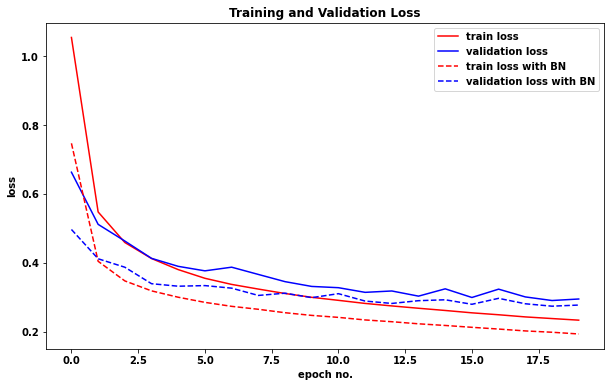

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see from the above curves that when we use Batch Normalization, the training converges much faster.

# <font style="color:blue">Miscellaneous: Calculate Mean and Standard Deviation of Fashion MNIST </font>

Ideally, we should not use the same mean and standard deviation for Fashion MNIST and MNIST, even though most people don't care much as it does not have a profound effect on the results.

But, we will find those numbers for Fashion MNIST and use it instead of the mean and standard deviation of MNIST. 

We need to simply find the mean and standard deviation of the whole dataset. So, we load the dataset and find it using the mean and std functions as given below:


In [16]:
import torchvision
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)

print(train_set.data.float().mean()/255)
print(train_set.data.float().std()/255)

tensor(0.2860)
tensor(0.3530)
